In [1]:
import pyspark
import dxpy
import hail as hl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

WD='/opt/notebooks'

In [2]:
my_database = dxpy.find_one_data_object(
    name="my_database", 
    project=dxpy.find_one_project()["id"]
)["id"]
database_dir = f'dnax://{my_database}'
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)
hl.init(sc=sc, tmp_dir=f'{database_dir}/tmp/')

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 2.4.4
SparkUI available at http://ip-10-60-79-234.eu-west-2.compute.internal:8081
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.78-b17627756568
LOGGING: writing to /opt/notebooks/hail-20220808-1501-0.2.78-b17627756568.log


## S0. Load data, functions

In [3]:
def get_bins(series, n_bins=100):
    if np.array_equal(series, series.astype(int)):
        step = 1
        n_steps = series.max()-series.min()
        while n_steps>100:
            n_steps /= 2
            step *= 2
        bins = np.arange(series.min(), series.max(), step=step)-0.5
    else:
        _, bins = np.histogram(series, n_bins)
        
    return bins

In [4]:
# Sample QC stats resulting from Hail .sample_qc()
# ** NOTE: Data was pre-filtered before sample_qc stats were generated **
# The "from_raw" is because the pre-filter was all performed in Hail from the raw VCFs, instead of using BCFtools to filter variants first.
# It DOES NOT mean these sample_qc stats come directly from the raw VCFs without a variant/genotype filter.
qc_stats = pd.read_csv(
    'file:///mnt/project/data/01_get_sample_stats/sample_qc_c21.tsv.gz',
    compression='gzip',
    sep='\t',
    dtype={'s':str}
)

cols_to_plot = [c for c in qc_stats.columns if (('n_' in c)|('.mean' in c)|('r_' in c)|(c=='call_rate')) & ((c!='n_not_called')&(c!='n_star'))]

# Annotate samples with superpopulation assignments from random forest classification
pops = pd.read_csv(
    'file:///mnt/project/data/superpopulation_labels.tsv',
    sep='\t',
    usecols=[0,1,2,13,14],
    dtype={
        'sample.ID':str,
        'super.population':str,
        'population':str
    }
)

pops = pops.rename(columns={'sample.ID':'s'})

qc_stats = qc_stats.merge(pops.iloc[:,:3], on='s')

superpops = qc_stats['classification_strict'].value_counts().index


# Annotate samples with tranche (50k, 150k, 250k)
samples_50k = pd.read_csv('/mnt/project/resources/ukb12788_wes_50k.sample_ids.txt', delim_whitespace=True, header=None, names=['eid_12788'], dtype=str)
samples_150k = pd.read_csv('/mnt/project/resources/ukb12788_wes_150k.sample_ids.txt', delim_whitespace=True, header=None, names=['eid_12788'], dtype=str)
sample_id_map = pd.read_csv('/mnt/project/resources/ukb11867_to_ukb12788.sample_ids.txt', delim_whitespace=True, dtype=str)

samples_50k = samples_50k.merge(sample_id_map, on='eid_12788')
samples_150k = samples_150k.merge(sample_id_map, on='eid_12788')

qc_stats['is_in_wes_50k'] = qc_stats.s.isin(samples_50k.eid_11867)
qc_stats['is_in_wes_150k'] = qc_stats.s.isin(samples_150k.eid_11867)

qc_stats['is_in_wes_250k'] = (qc_stats['is_in_wes_50k']==False) & (qc_stats['is_in_wes_150k']==False)

tranches = ['250k', '150k', '50k']

In [5]:
# version = 'rf_gt_filter' # Really should be called "prefilter_v1.0"
version = 'prefilter_v1.1'

## S1. Plot with no stratification

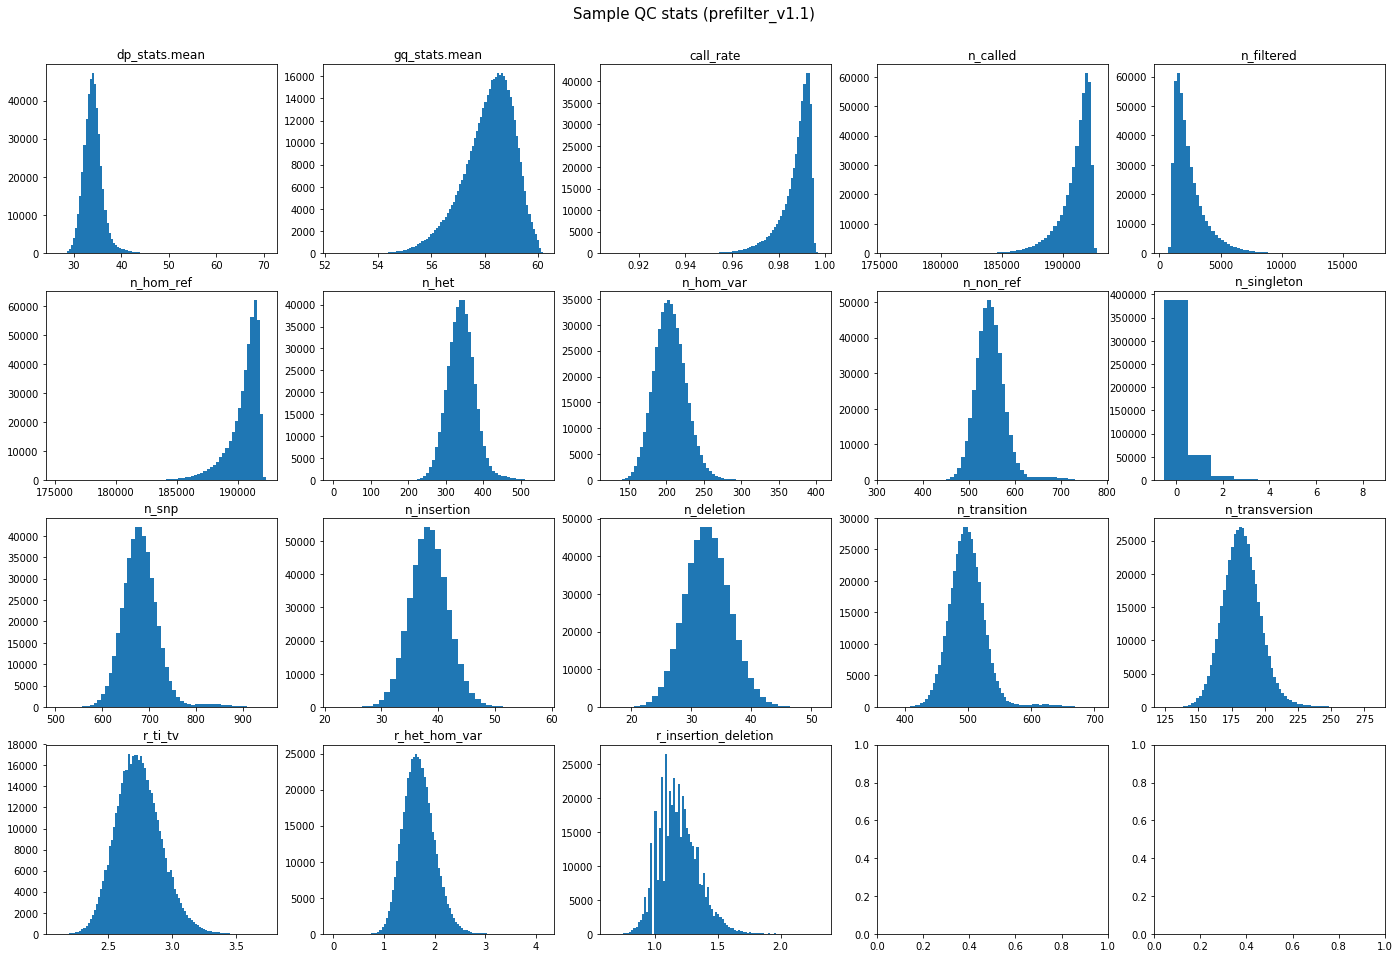

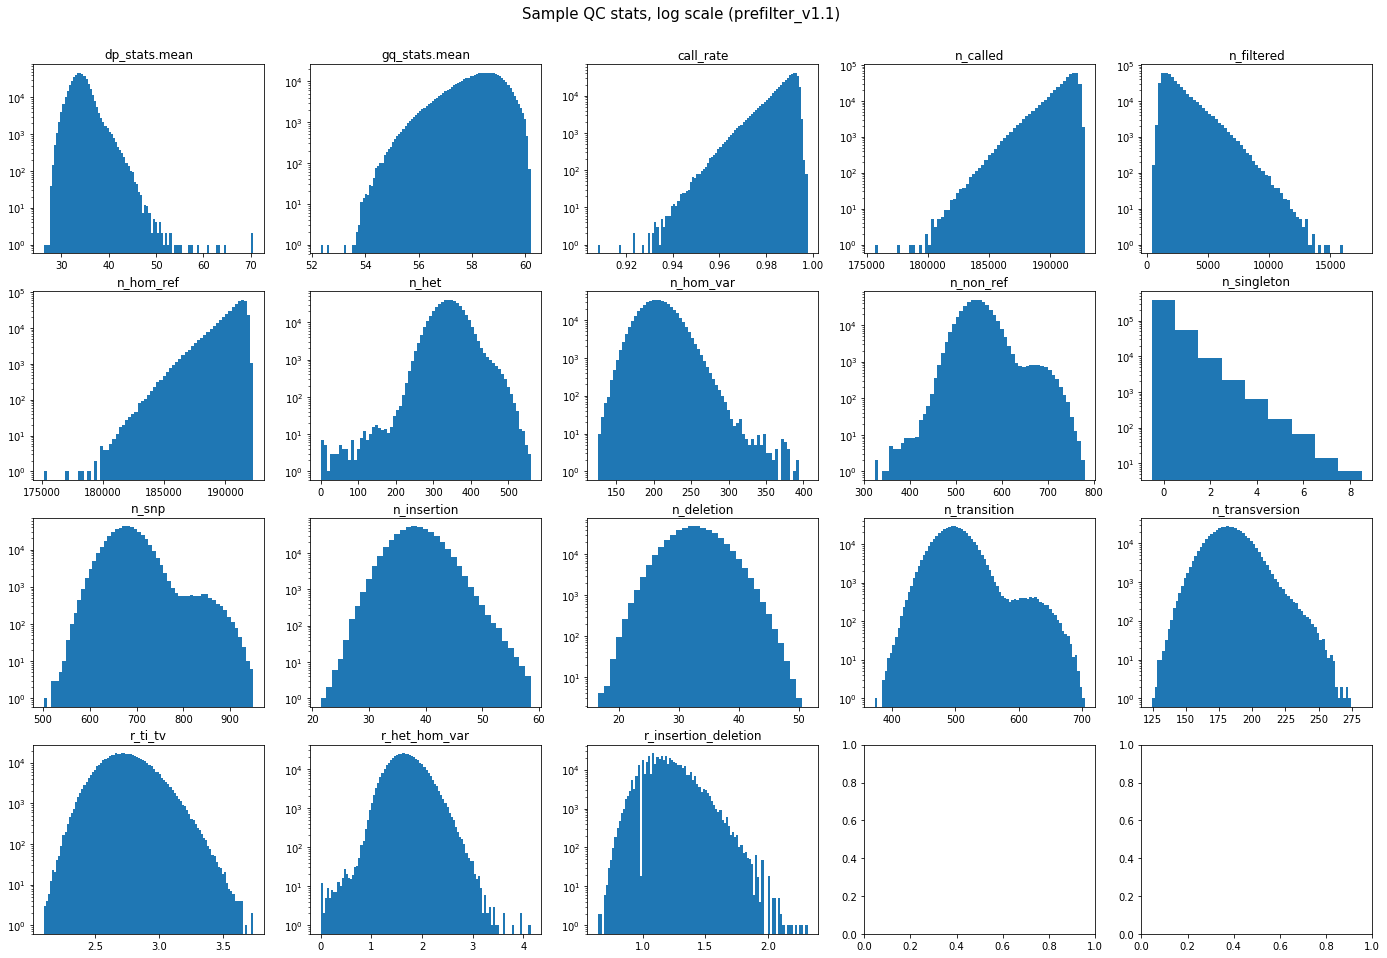

In [14]:
nrows=4
ncols=5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    ax.hist(qc_stats[col], bins=bins)
    ax.set_title(col)
plt.suptitle(f'Sample QC stats ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.png', dpi=300)
    
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    ax.hist(qc_stats[col], bins=bins)
    ax.set_yscale('log')
    ax.set_title(col)
plt.suptitle(f'Sample QC stats, log scale ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.logscale.png', dpi=300)

In [10]:
# Using VCFs which were RF-filtered by bcftools before genotype filter and sample QC
# pre = pd.read_csv(
#     'file:///mnt/project/data/02_get_sample_stats/sample_qc_c21.tsv.gz',
#     compression='gzip',
#     sep='\t'
# )

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# pre

,s,dp_stats.mean,dp_stats.stdev,dp_stats.min,dp_stats.max,gq_stats.mean,gq_stats.stdev,gq_stats.min,gq_stats.max,call_rate,...,n_singleton,n_snp,n_insertion,n_deletion,n_transition,n_transversion,n_star,r_ti_tv,r_het_hom_var,r_insertion_deletion
0,1000010,29.501,15.839,10.0,302.0,52.452,13.469,20.0,99.0,0.58155,...,0,1194,77,75,840,354,0,2.3729,2.0788,1.02670
1,1000028,28.452,14.179,10.0,235.0,51.634,13.798,20.0,99.0,0.50207,...,1,1127,70,75,810,317,0,2.5552,1.3125,0.93333
2,1000034,29.794,17.684,10.0,249.0,52.669,13.247,20.0,99.0,0.58533,...,0,1358,78,86,984,374,0,2.6310,1.7955,0.90698
3,1000045,28.849,15.027,10.0,243.0,51.682,13.813,20.0,99.0,0.57600,...,0,1250,83,72,889,361,0,2.4626,1.8705,1.15280
4,1000052,29.250,18.481,10.0,306.0,51.688,13.749,20.0,99.0,0.65517,...,0,1295,101,87,940,355,0,2.6479,1.9337,1.16090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454666,W000046,31.388,23.458,10.0,335.0,52.232,13.668,20.0,99.0,0.64041,...,0,1494,119,101,1070,424,0,2.5236,2.2321,1.17820
454667,W000047,29.953,22.180,10.0,315.0,51.669,13.788,20.0,99.0,0.66475,...,0,1326,108,85,974,352,0,2.7670,2.1390,1.27060
454668,W000048,29.190,18.347,10.0,278.0,51.794,13.768,20.0,99.0,0.60751,...,1,1327,94,83,962,365,0,2.6356,1.7320,1.13250
454669,W000049,28.749,16.564,10.0,240.0,51.506,13.835,20.0,99.0,0.60369,...,0,1364,89,94,971,393,0,2.4707,1.5645,0.94681


## S2. Plotting with superpopulation labels

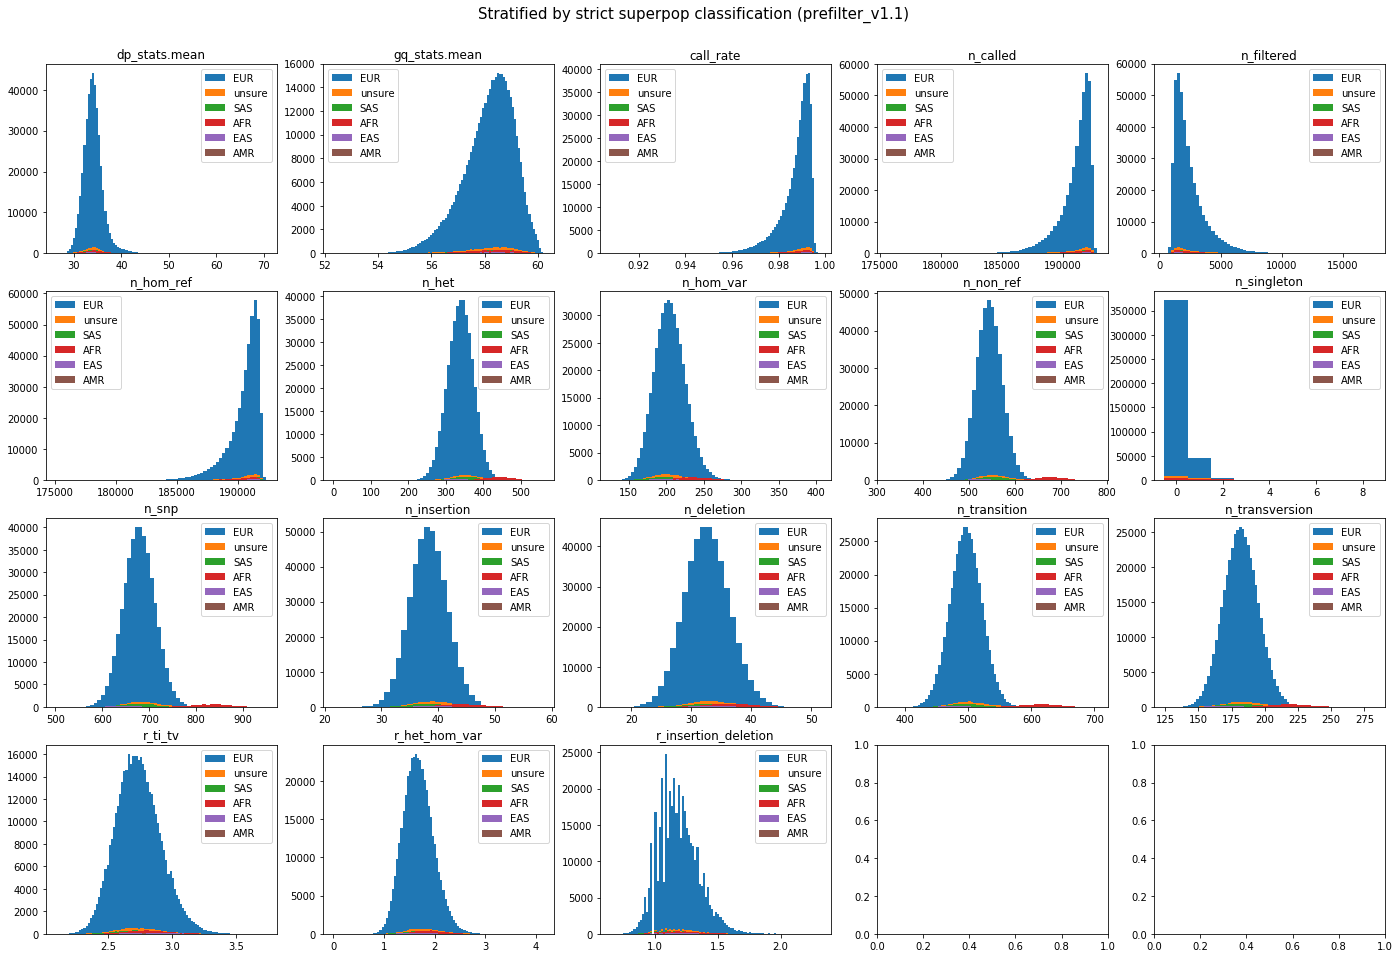

In [11]:
n_bins = 100

nrows=4
ncols=5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(series=qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    for pop in superpops:
        ax.hist(qc_stats.loc[qc_stats['classification_strict']==pop, col], bins=bins, label=pop)
    ax.set_title(col)
    ax.legend()
plt.suptitle(f'Stratified by strict superpop classification ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.strat_by_strict_superpop.png', dpi=300)

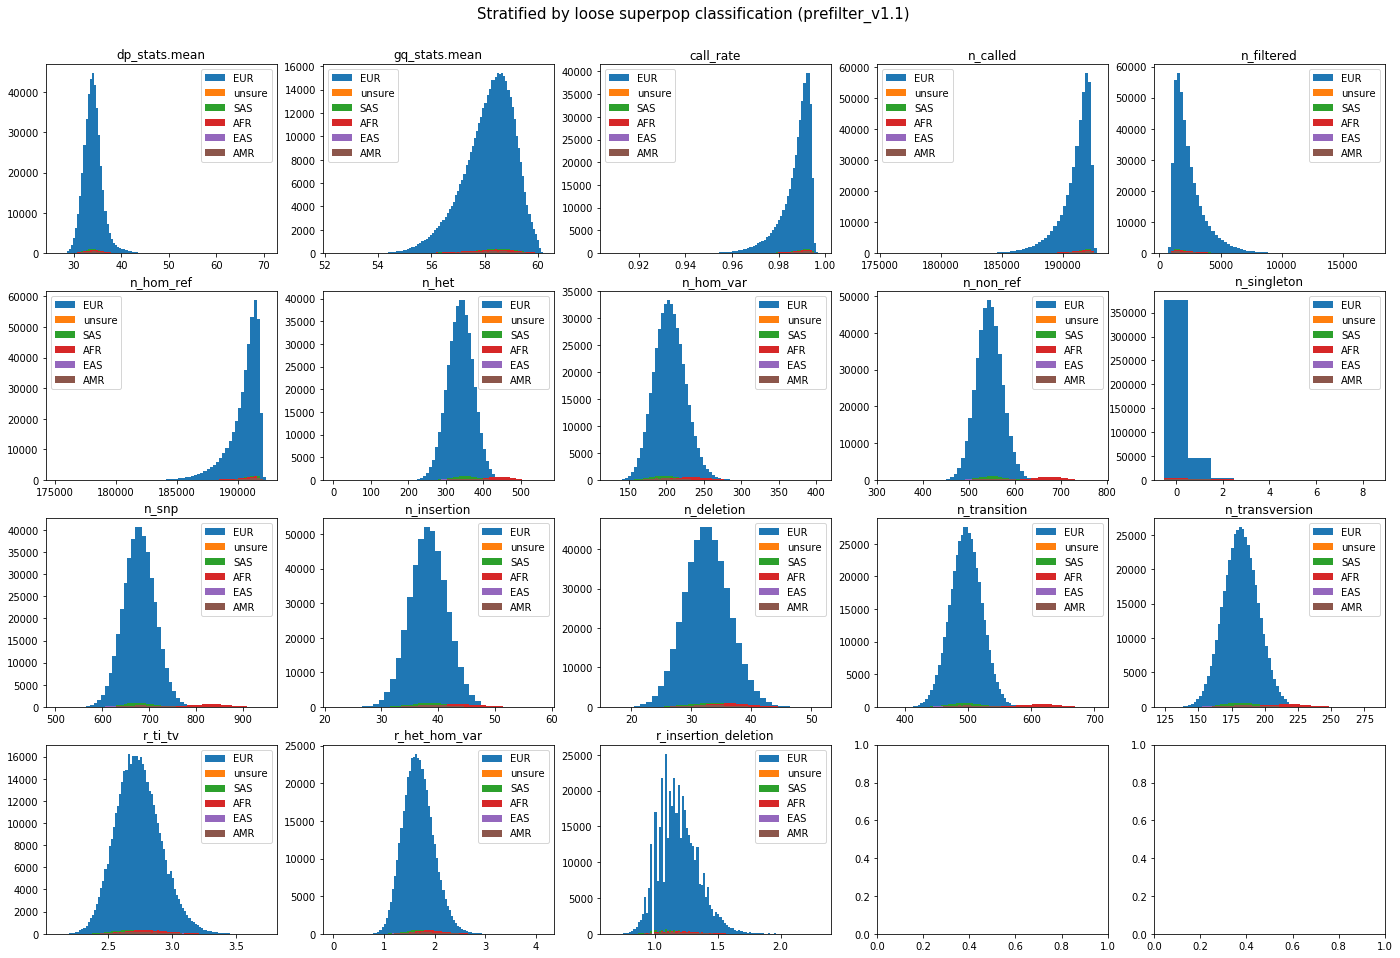

In [12]:
n_bins = 100

nrows=4
ncols=5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    for pop in superpops:
        ax.hist(qc_stats.loc[qc_stats['classification_loose']==pop, col], bins=bins, label=pop)
    ax.set_title(col)
    ax.legend()
plt.suptitle(f'Stratified by loose superpop classification ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.strat_by_loose_superpop.png', dpi=300)

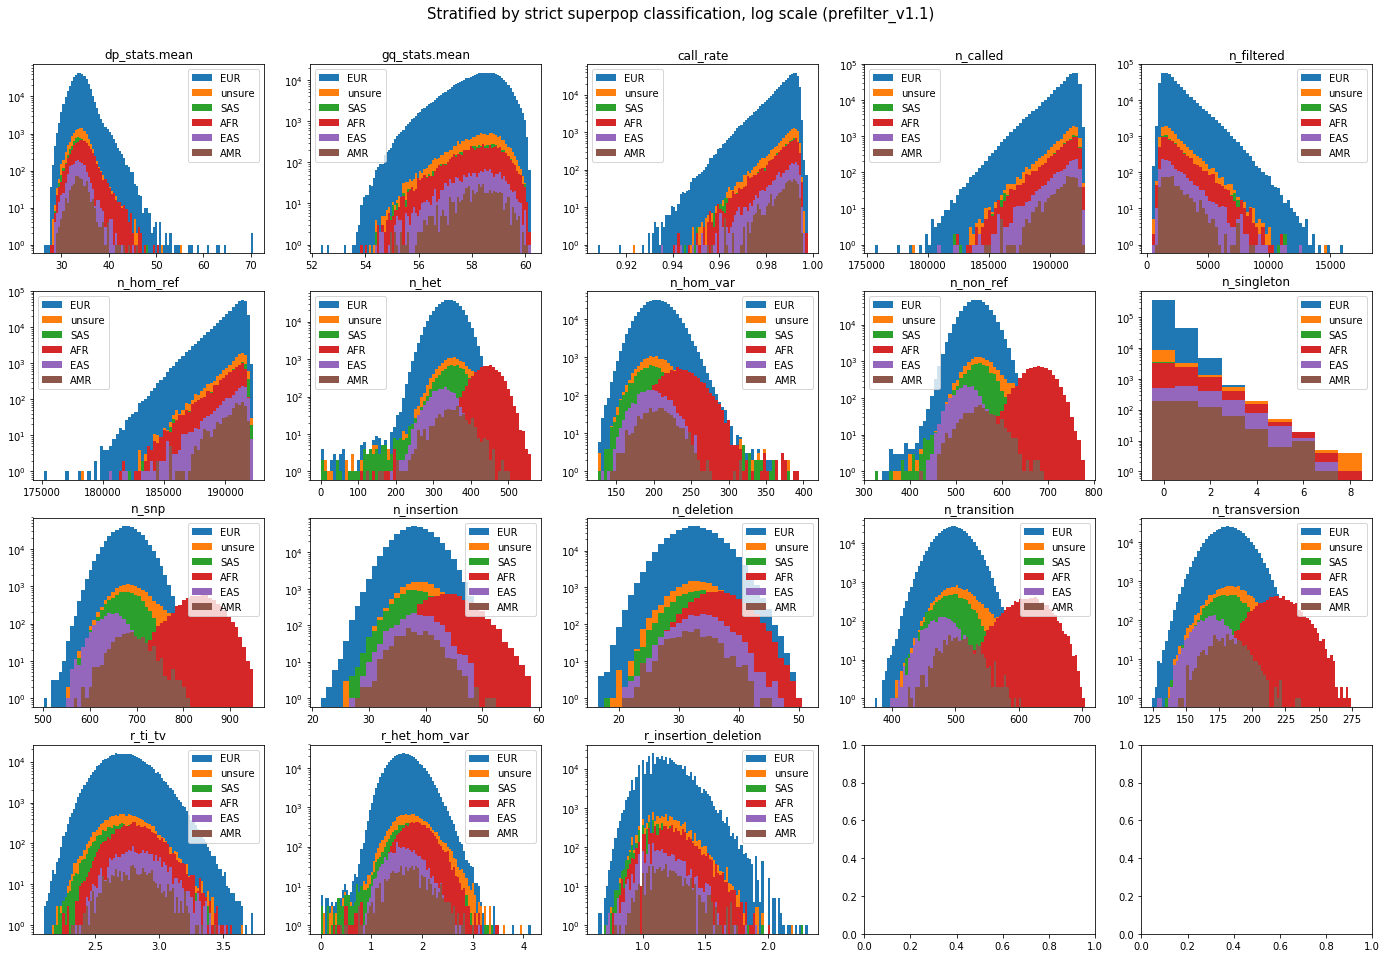

In [13]:
n_bins = 100

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    for pop in superpops:
        ax.hist(qc_stats.loc[qc_stats['classification_strict']==pop, col], bins=bins, label=pop)
    ax.set_yscale('log')
    ax.set_title(col)
    ax.legend()
plt.suptitle(f'Stratified by strict superpop classification, log scale ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.strat_by_strict_superpop.logscale.png', dpi=300)

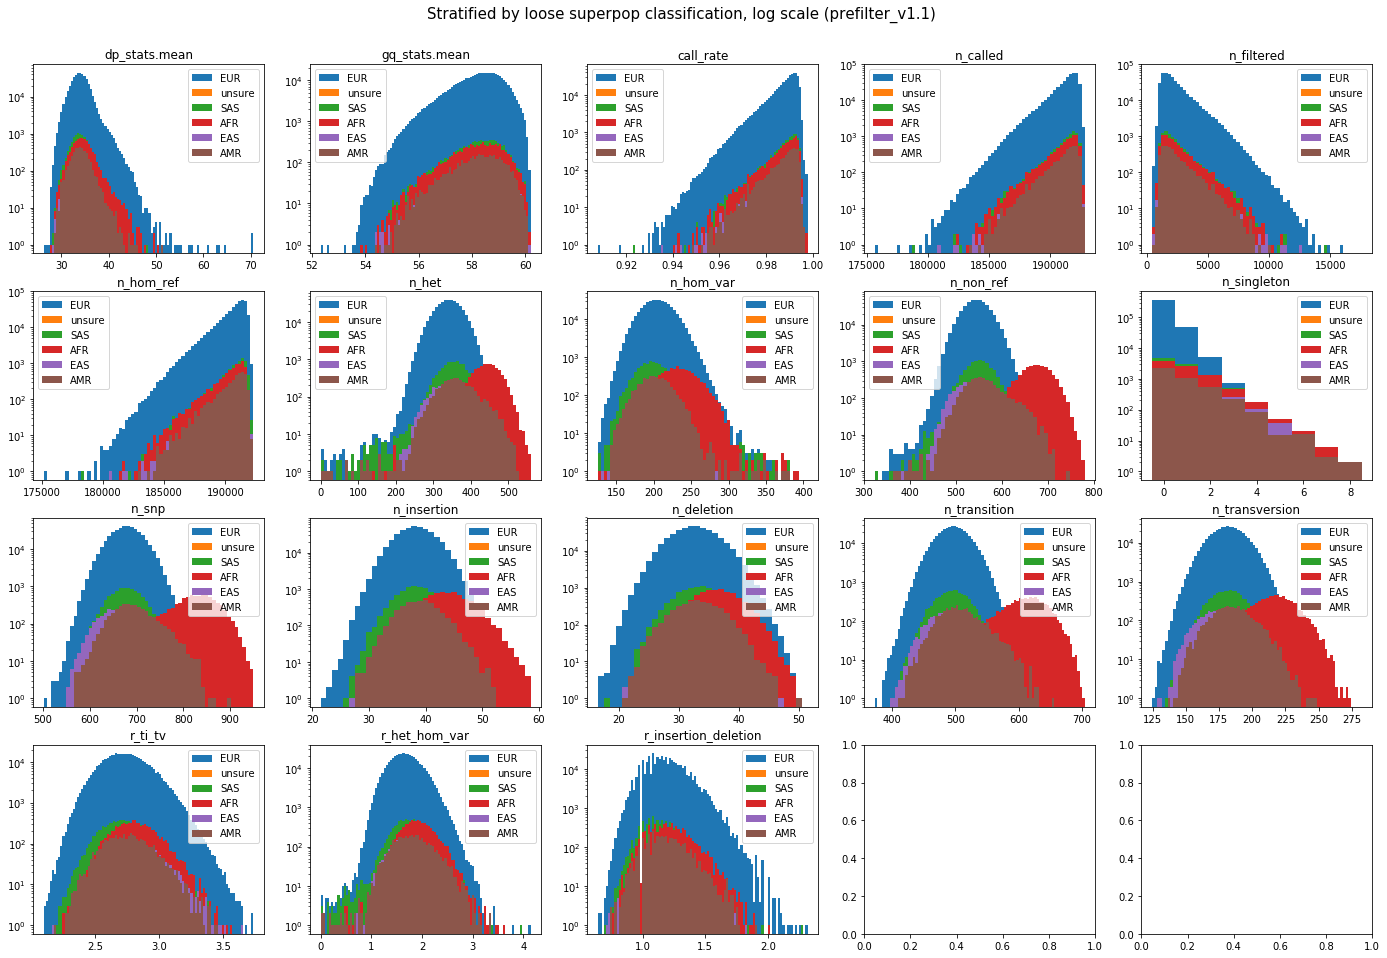

In [15]:
n_bins = 100

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    for pop in superpops:
        ax.hist(qc_stats.loc[qc_stats['classification_loose']==pop, col], bins=bins, label=pop)
    ax.set_yscale('log')
    ax.set_title(col)
    ax.legend()
plt.suptitle(f'Stratified by loose superpop classification, log scale ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.strat_by_loose_superpop.logscale.png', dpi=300)

## S3. Plotting by tranche

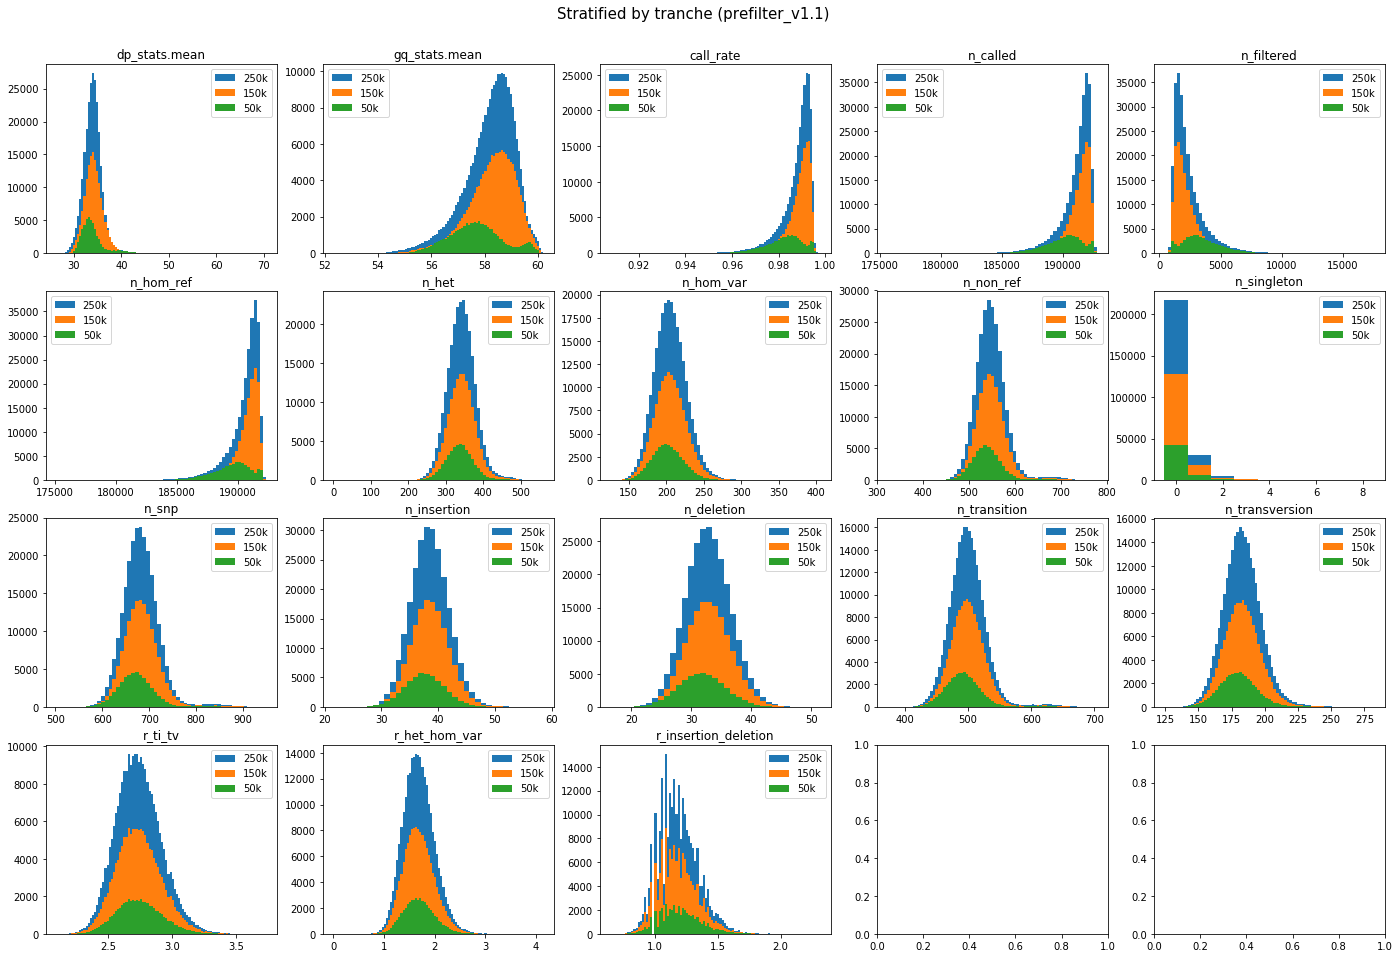

In [16]:
n_bins = 100

nrows = 4
ncols = 5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    for tranche in tranches:
        ax.hist(qc_stats.loc[qc_stats[f'is_in_wes_{tranche}']==True, col], bins=bins, label=tranche)
    ax.set_title(col)
    ax.legend()
plt.suptitle(f'Stratified by tranche ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.strat_by_tranche.png', dpi=300)

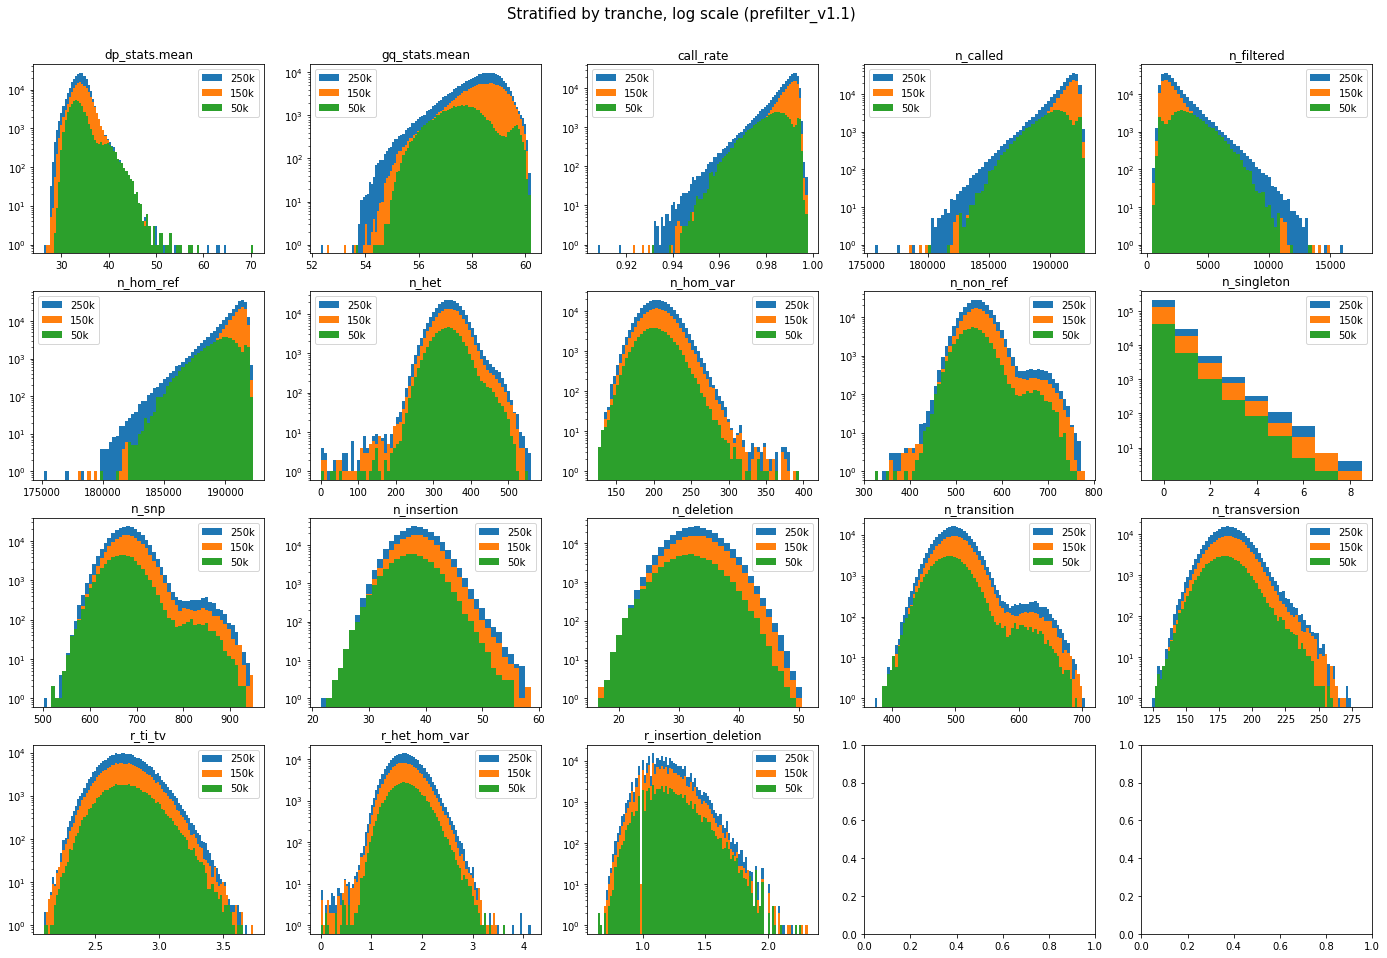

In [17]:
n_bins = 100

nrows = 4
ncols = 5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,16))
for idx, col in enumerate(cols_to_plot):
    bins = get_bins(qc_stats[col])
    ax = axs[idx//ncols][idx%ncols]
    for tranche in tranches:
        ax.hist(qc_stats.loc[qc_stats[f'is_in_wes_{tranche}']==True, col], bins=bins, label=tranche)
    ax.set_yscale('log')
    ax.set_title(col)
    ax.legend()
plt.suptitle(f'Stratified by tranche, log scale ({version})', y=0.93, size=15)
plt.savefig(f'{WD}/ukb_wes_450k.{version}.sample_qc.strat_by_tranche.logscale.png', dpi=300)

## S4. MAD filters

In [18]:
def mad_filter(df, n_mads, fields_to_filter = ['n_deletion','n_insertion','n_snp', 'r_insertion_deletion','r_ti_tv','r_het_hom_var']):
    print(f'** {version} **')
    print(f'** n_mads = {n_mads} **\n')
    for tranche in tranches:
        for pop in superpops:
            if pop=='unsure':
                continue
            is_subgroup = (df.classification_loose==pop)&(df[f'is_in_wes_{tranche}'])
            print(tranche, pop, is_subgroup.sum())
            for field in fields_to_filter:
                median = np.median(df.loc[is_subgroup, field])
                mad = stats.median_abs_deviation(df.loc[is_subgroup, field])
                is_fail = (df[field] < median - n_mads*mad) | (df[field] > median + n_mads*mad)
                df.loc[is_subgroup, f'fail_{field}'] = False
                df.loc[is_subgroup & is_fail, f'fail_{field}'] = True
                print(f' - fail {field}: {df.loc[is_subgroup & is_fail, f"fail_{field}"].sum()}')
            subgroup = df.loc[is_subgroup, [f"fail_{field}" for field in fields_to_filter]]
            print(f' * total fail: {(subgroup.sum(axis=1)>0).sum()}')

    print(f'\n** total failed: {(df[[f"fail_{field}" for field in fields_to_filter]].sum(axis=1)>0).sum()} **')
    
    return df

In [19]:
filtered = mad_filter(
    df=qc_stats, 
    n_mads=4, 
)

** prefilter_v1.1 **
** n_mads = 4 **

250k EUR 240673
 - fail n_deletion: 4721
 - fail n_insertion: 2232
 - fail n_snp: 1959
 - fail r_insertion_deletion: 2877
 - fail r_ti_tv: 2439
 - fail r_het_hom_var: 2294
 * total fail: 14763
250k SAS 5058
 - fail n_deletion: 100
 - fail n_insertion: 59
 - fail n_snp: 44
 - fail r_insertion_deletion: 85
 - fail r_ti_tv: 44
 - fail r_het_hom_var: 102
 * total fail: 382
250k AFR 4673
 - fail n_deletion: 5
 - fail n_insertion: 14
 - fail n_snp: 83
 - fail r_insertion_deletion: 62
 - fail r_ti_tv: 59
 - fail r_het_hom_var: 55
 * total fail: 260
250k EAS 1266
 - fail n_deletion: 29
 - fail n_insertion: 22
 - fail n_snp: 10
 - fail r_insertion_deletion: 23
 - fail r_ti_tv: 12
 - fail r_het_hom_var: 13
 * total fail: 97
250k AMR 2257
 - fail n_deletion: 2
 - fail n_insertion: 39
 - fail n_snp: 46
 - fail r_insertion_deletion: 38
 - fail r_ti_tv: 23
 - fail r_het_hom_var: 35
 * total fail: 172
150k EUR 141943
 - fail n_deletion: 85
 - fail n_insertion: 1

In [ ]:
filtered = mad_filter(
    df=qc_stats, 
    n_mads=4, 
)

** n_mads = 4 **

250k EUR 240673
 - fail n_deletion: 2696
 - fail n_insertion: 3233
 - fail n_snp: 1989
 - fail r_insertion_deletion: 2237
 - fail r_ti_tv: 2172
 - fail r_het_hom_var: 2588
 * total fail: 12157
250k SAS 5058
 - fail n_deletion: 57
 - fail n_insertion: 64
 - fail n_snp: 36
 - fail r_insertion_deletion: 54
 - fail r_ti_tv: 47
 - fail r_het_hom_var: 116
 * total fail: 318
250k AFR 4673
 - fail n_deletion: 37
 - fail n_insertion: 40
 - fail n_snp: 18
 - fail r_insertion_deletion: 44
 - fail r_ti_tv: 45
 - fail r_het_hom_var: 91
 * total fail: 241
250k EAS 1266
 - fail n_deletion: 9
 - fail n_insertion: 7
 - fail n_snp: 8
 - fail r_insertion_deletion: 20
 - fail r_ti_tv: 10
 - fail r_het_hom_var: 21
 * total fail: 67
250k AMR 2257
 - fail n_deletion: 12
 - fail n_insertion: 38
 - fail n_snp: 22
 - fail r_insertion_deletion: 20
 - fail r_ti_tv: 15
 - fail r_het_hom_var: 33
 * total fail: 121
150k EUR 141943
 - fail n_deletion: 596
 - fail n_insertion: 1407
 - fail n_snp: 861